# RNN Labb (endast G)

Ni ska skapa ett nätverk som kan klassificera känslor i text. Varje text består av en mening och har en känsla kopplad till sig. Datasetet som ska användas finns på ithsdistans. Koden ska skrivas i en jupyter notebook och den ska vara välstrukturerad och hålla god kod-kvalité. (T.ex. Använd väl valda variabelnamn och kommentarer där det behövs.)

## Frågor:

*Please note: Throughout this analysis, if I don't explicitly type out the difference between validation and test accuracy, it's because the two are similar enough (within 1 percentage point), in my view, to not need to type them both out. However, if more detailed comparisons are required, I am more than happy to re-run all iterations and update the answers*

- **Motivera din modellarkitektur och val av relevanta hyperparametrar.**
    - I've chosen to use SimpleRNN instead of LSTM or LSTM-GRU. This helps speed up the training process quite alot (by a factor of about 4). I started off with a super simple model: 
    ```py
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(layers.SimpleRNN(256, activation='tanh'))

    model.add(Dense(256, activation='tanh'))
    model.add(Dense(6, activation='softmax'))
    ```
    However, validation & test score was around 30%, which is pretty terrible. After looking online for abit I saw that perhaps adding a 1D Convolutional layer and a Maxpooling layer might help:
    ```py
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.SimpleRNN(256, activation='tanh'))
    model.add(Dense(256, activation='tanh'))
    model.add(Dense(6, activation='softmax'))
    ```
    With the addition of these layers, the validation and test score impressively increased to about 88%. This suggests that the applied filters are capturing strong and significant patterns in the sequenced text. The max pooling layer might enhance this fruther by filtering out the most pertinent information from these features. However, this is just a general guess.

    I then wanted to add one more convolutional and pooling layer to see if I could easily get higher validation & test score. This seemed to work:
    ```py
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.SimpleRNN(256, activation='tanh'))
    model.add(Dense(256, activation='tanh'))
    model.add(Dense(6, activation='softmax'))
    ```
    This managed to get validation & test score up to about 90.5%, which is good, however I can clearly see that the model i abit overfitted (not too badly though), so the next step is to add dropout after each conv/pooling layer:
    ```py
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling1D(5))
    model.add(Dropout(0.4))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling1D(5))
    model.add(Dropout(0.4))
    model.add(layers.SimpleRNN(256, activation='tanh'))
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(6, activation='softmax'))
    ```
    They didn't seem to affect the model that much, however I managed to get test and validation score accuracy to about 91% atleast. When i then also added l2 regularization to our convolutional layers it seemed to help the overfitting slightly, however, this caused validation and test score to go down to about 86%. I did get this number up to about 91% (both val and test) by just playing around with l2 hyperparameter (0.01 to 0.001), and I also added a second SimpleRNN layer which seemed to help slightly, I also added dropout as a hyperparameter for these layers. Adding RNN layers like this will increase the amount of parameters (1,1m to 1.6), which is important to keep in mind because I'm not using the most powerful computer in order to train the model:
    ```py
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling1D(5))
    model.add(Dropout(0.4))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling1D(5))
    model.add(Dropout(0.4))
    model.add(layers.SimpleRNN(256, activation='tanh', return_sequences=True, dropout=0.2))
    model.add(layers.SimpleRNN(512, activation='tanh', dropout=0.2))
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(6, activation='softmax'))
    ```
    I then tested LSTM, LSTM-GRU & Bidirectional layers instead of only SimpelRNN layers. Here's the result of all the combinations i tested:

        - Only SimpleRNN: 1.5m parameters | ~91% val and test acc
        - Only LSTM: 3m parameters | ~89% val and test acc
        - Only GRU: 2.6m parameters | ~89% val and test acc

        - Bidirectional SimpleRNN: 2.5m parameters | ~90.5% val and test acc
        - Bidirectional LSTM: 6.2m parameters | ~89% val and test acc
        - Bidirectional GRU: 4.9m parameters | ~91% val and test acc

    Only SimpleRNN seems like the way to go in this case. I also attempted to add a 3rd Convolutional layer, however, the already existing two layers reduce too much data to also add a third layer. I increased the amount of nodes on all layers to check if it affected performance. The only thing that happened was that the amount of parameters shot up to about 5 million, but very slight change otherwise.
    
    This is the final iteration of my model: 

    ```py
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling1D(5))
    model.add(Dropout(0.4))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling1D(5))
    model.add(Dropout(0.4))
    model.add(layers.SimpleRNN(256, activation='tanh', return_sequences=True, dropout=0.2))
    model.add(layers.SimpleRNN(512, activation='tanh', dropout=0.2)) # 512
    model.add(Dense(256, activation='tanh')) #256
    model.add(Dropout(0.4))
    model.add(Dense(6, activation='softmax'))
    ```
    I noticed that the data augmentation part of the code had issues with it not working properply after I had initially turned in the labb. The issue did not happen until today (01-16), and I had thought that it was a visual bug, but it wasnt. Having fixed this small issue, now the model (same as last iteration) managed to get up 93.6% accuracy (up from 92.5%) which is a happy supprise.

- **Vilka aktiveringsfunktioner har du använt? Varför?**
    - RNN's commonly use Tanh or sigmoid. There are apparently also examples when using LSTMs where both AF are used. In this case, I'm testing each separately and using the one with the best scoring (val & test acc), which was Tanh for the case of SimpleRNN layers:
        - ReLU: ~87%
        - Sigmoid: got stuck at ~34% (not sure exactly why this happened, even when i re-ran all cells)
        - Tanh: ~90%
    - For the convolutional layers I chose to go with ReLu, this is because when I was testing, I noticed that ReLu scored 1% point higher than tanh, which suggests that the commonly used activation function for RNN's don't apply to the convolutional layers.
    - For the output I've chosen to go with the softmax AF, this is because our problem here is a multiclass classification problem. We're predicting a single output for each prediction, each sentence only has one classification (atleast that is what I'm assuming).
- **Vilken loss funktion har du använt? Varför?**
    - Since I've done simple label encoding, the best option seems to be sparse categorical crossentropy. This is because sparse categorical crossentropy is used when your classes are mutually exclusive, which is the same reasoning as when choosing output layer AF.
- **Har du använt någon databehandling? Motivera dina val.**
    - I've removed stopwords from the dataset, aswell as made sure that the text is all lower case. This is ofcourse to remove unecessary data that doesn't affect the outcome of the model, this also makes the model more efficient. I also added a few variations of stopwords to the list since I saw that they were missing. In this case the dataset had examples of not using "'" for a few words. Examples would be: "youre" instead of "you're" etc.. 
    - I also did some feature engineering by counting words and characters for each sentence and then adding these numbers to a another column. However, It doesn't seem like this was needed in this case and I removed it from the dataframe. 
    - Tokenization & padding was also added. Tokenization was to convert the text into something that an RNN model would be able to understand, i.e convert to numbers. I then padded each row with 0's, and this is to have the input be the same shape. It also truncates the sentences if they're longer than what I've specified (which doesn't happen in this case, however, if more data is added later on, then this might be the case).
    - The last thing I also did was to try and balance out the dataset with data augmentation. I checked which label had the most data, then created code which augmented and added data until the labels had the same count as the "joy" label. 
- **Har du använt någon regulariseringsteknik? Motivera.**
    - I've used quite alot of regularization, what's odd though is that it doesn't seem to affect the overfitting too much overall. Sure, it helps abit, but not as much as it affected the CNN model we created for example. I wonder if this has to do with it being an RNN model, or perhaps a text-based dataset?
- **Hur har modellen utvärderats?**
    - I've plotted out training and validation data to get a picture of how overfit the model is, I've also added a confusion matrix. Since the dataset was originally very unbalanced, I wanted to see how prediction accuracy differed between the labels. To end the evaluation I check how well the model performs on test data by checking accuracy and loss.
- **Är prestandan bra? Varför/ varför inte?**
    - I would say that the model is actually doing pretty well, I think I've done my best to try and exhaust every avenue when it comes to bettering the model. The main thing that really shot up the accuracy score was adding 1D convolutional layers. It really seemed like they fit our problem here very well.
- **Vad hade du kunnat göra för att förbättra den ytterligare?**
    - Spend more time on data augmentation because I feel like it's such a powerful tool if you use well, it's basically free data, which is so increadibly important for machine learning.
        - For example: Andreas and I were discussing data augmentation, and he told me that it's possible to translate from one language to another, then back. This in turn creates basically a paraphrased sentence of the original, however, the original meaning of the sentence stays the same, but you get essentially new data.
    - Utilize the confusion matrix. I can clearly see that certain labels are more easily predicted compared to others. This obviously helps you focus on what needs to be looked into and improved, instead of just trying to change the dataset in a general sense, which impacts every label.
        - For example: why are there 60 incorrectly predicted labels with "love", when the actual label is "joy"? And, why are there only 2 incorrectly predicted labels with "sadness", when the actual label is "love"? Just looking this up to type this example, I realise that "joy" and "love" are most likely very similar and overlap with eachother more often than "sadness" and "love". Can I change this somehow? Or would it be too difficult?
    - Dive deeper into regularization. Right now, I just select values that I see online and have used before without really understand why that value works well or not.
- **Generativ AI har blivit stort inom text. Beskriv skillnaden mellan generativ ai och mer traditionell ai.**
    - Traditional AI are more rule-bound, this means that they're utilizing a specific amount of algorithms and rely on explicit programming by someone. The thought here being that we have more control and understand what the AI excels at, aswell as its boundaries. This is atleast what we initally thought AI would be, and there have been plenty of movies showcasing the issues with AI, even in its traditional form. Mainly, that there might be some sort of oversight in the creation leading to unintended self-serving behavior by the AI.
    - When it comes to generative AI, there is more a flexible approach, where certain mathematical and statistical concepts act as building blocks for an unlimited amount of use-case specific algorithms, which then in turn generate new data, often improving through feedback loops iteratively. The boundaries of generative AI are more neboulus and less predictable, which means that the potential of generative AI is nearly endless. This in turn obviously mean that it can be used both for good and evil. Companies exploring generative AI seem to take this seriously, meaning that they are implementing safeguards (atleast for their own creations), making the use of generative AI safer for everyone. 



In [53]:
import pandas as pd
from loguru import logger
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import Sequential
import keras
from keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import keras_tuner as kt
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.layers import Dropout, Dense


from statistics import mean, median
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas import DataFrame, Series
from loguru import logger

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D

from tensorflow.keras import backend as K
import numpy as np
from collections import Counter
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import confusion_matrix, classification_report

df = pd.read_csv("emotions.csv")
pd.set_option("display.max_colwidth", None)  # to be able to read entire text

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [55]:
df.isnull().sum()

text     0
label    0
dtype: int64

### Creates new column that has word count of each sentence
#### Also gives general information about the texts

In [56]:
def character_counter_for_sentences(column: Series) -> list:
    sentence_length_characters = []
    for row, text in enumerate(column.iloc):
        sentence_length_characters.append(len(text))
    return sentence_length_characters


def word_counter_for_sentences(column: Series) -> list:
    sentence_length_words = []
    for row, text in enumerate(column.iloc):
        sentence_length_words.append(len(text.split()))
    return sentence_length_words


def word_or_character_length(
    word_or_character_amount: int, word_or_character_list: list
) -> print:
    above_100_length = [
        length >= word_or_character_amount for length in word_or_character_list
    ]
    is_above_100 = above_100_length.count(True)
    is_not_above_100 = above_100_length.count(False)

    above_or_equal_print = print(
        f"\nRows that are ABOVE or EQUAL to {word_or_character_amount} characters long: {is_above_100}"
    )
    below_print = print(
        f"Rows that are BELOW {word_or_character_amount} characters long: {is_not_above_100}"
    )
    return above_or_equal_print, below_print


def print_metrics_for_characters_or_words(
    word_or_character: str, word_or_character_list: list
) -> print:
    print_median = print(
        f"Median Length {word_or_character}:", median(word_or_character_list)
    )
    print_mean = print(
        f"Average Length {word_or_character}:", mean(word_or_character_list)
    )
    print_min = print(
        f"Smallest Length {word_or_character}:", min(word_or_character_list)
    )
    print_max = print(
        f"Longest Length {word_or_character}:", max(word_or_character_list), "\n"
    )
    return print_median, print_mean, print_min, print_max


text_rows = df["text"]

sentence_length_characters = character_counter_for_sentences(text_rows)
df[
    "character_amount"
] = sentence_length_characters  # add new column with character length

sentence_length_words = word_counter_for_sentences(text_rows)
df["word_amount"] = sentence_length_words  # add new column with word length

word_or_character_length(20, sentence_length_words)
word_or_character_length(100, sentence_length_characters)
print_header = print("\n---LENGTH OF SENTENCES IN DATASET---")
print_metrics_for_characters_or_words("Characters", sentence_length_characters)
print_metrics_for_characters_or_words("Words", sentence_length_words)


Rows that are ABOVE or EQUAL to 20 characters long: 8276
Rows that are BELOW 20 characters long: 11724

Rows that are ABOVE or EQUAL to 100 characters long: 8099
Rows that are BELOW 100 characters long: 11901

---LENGTH OF SENTENCES IN DATASET---
Median Length Characters: 86.0
Average Length Characters: 96.67005
Smallest Length Characters: 7
Longest Length Characters: 300 

Median Length Words: 17.0
Average Length Words: 19.13505
Smallest Length Words: 2
Longest Length Words: 66 



(None, None, None, None)

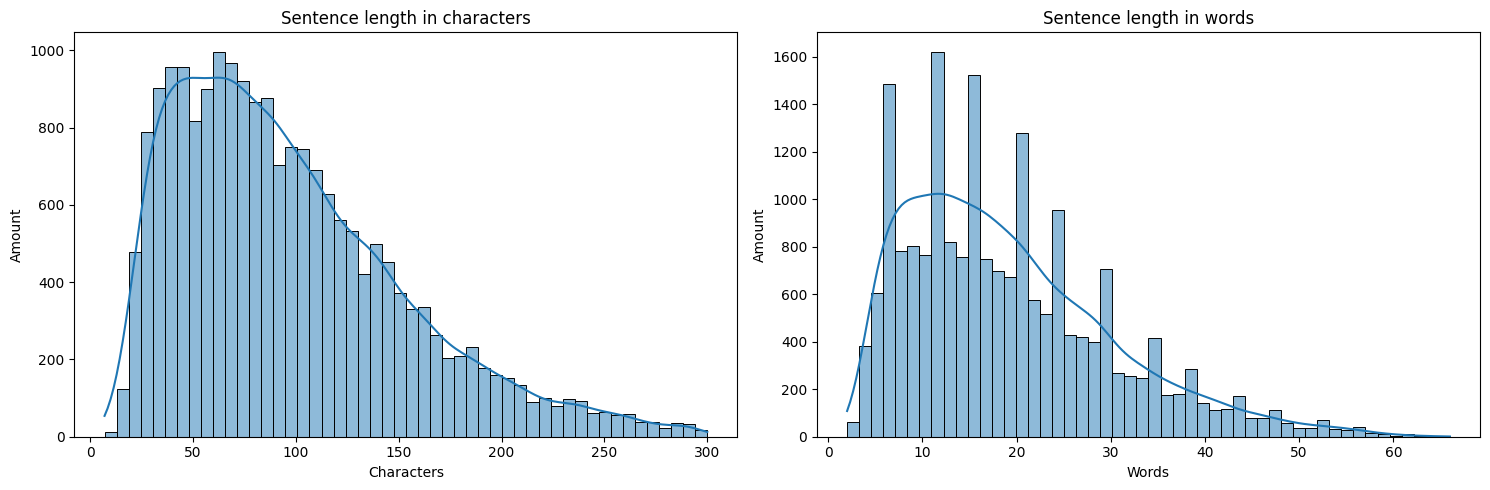

In [57]:
def length_words_and_characters_histplot(
    size_x=1, size_y=2, figsizes=(15, 5), bin=50, kde=True
) -> sns.histplot: 
    fig, axs = plt.subplots(size_x, size_y, figsize=figsizes)

    sns.histplot(df["character_amount"], bins=bin, kde=kde, ax=axs[0])
    axs[0].set_title("Sentence length in characters")
    axs[0].set_xlabel("Characters")
    axs[0].set_ylabel("Amount")

    sns.histplot(df["word_amount"], bins=bin, kde=kde, ax=axs[1])
    axs[1].set_title("Sentence length in words")
    axs[1].set_xlabel("Words")
    axs[1].set_ylabel("Amount")

    plt.tight_layout()
    plt.show()


length_words_and_characters_histplot()

## Emotion distribution

In [58]:
emotions = df["label"].unique()
emotions_count = df["label"].value_counts()

for i in emotions:
    print(i)

print(f"\n{emotions_count}")

anger
sadness
joy
love
fear
surprise

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label, dtype: int64


## Removing stop words

In [59]:
nltk_stopwords = stopwords.words("english")  # set language stopwords
print(f"\nStopwords: {nltk_stopwords}")  # prints list of stopwords in module

# dataframe has words without apostrophy
# so I added every word but without any apostrophies to the stopwords list so we're not missing any stopwords
nltk_stopwords_no_apostrophy = [word.replace("'", "") for word in nltk_stopwords]
nltk_stopwords.extend(nltk_stopwords_no_apostrophy)


Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [60]:
def remove_stopwords_from_df(df: DataFrame) -> str:
    words = df.split()  # only sentences - split makes each row list of words
    filtered_words = [
        word for word in words if word.lower() not in nltk_stopwords
    ]  # keep words that arent in stopword list
    filtered_sentence = " ".join(filtered_words)  # list -> string again
    return filtered_sentence


df["text"] = df["text"].apply(
    remove_stopwords_from_df
)  # each replaced with filtered sentence

## Data augmentation

In [61]:
sentences = df["text"]
labels = df["label"]

target_label_count = df[df["label"]=="joy"].shape[0] # counts how many rows of "joy" the dataset has

def augmented_sentences(sentence):
    words = sentence.split()
    augmentation_num = random.randint(1, 3) # selects a random amount of augmentations (1 to 3)
    for i in range(augmentation_num):
        augmentation_type = random.choice(["insert", "swap", "delete"]) # selects 1-3 augmentation types to apply
        # for each sentence that is selected 1-3 augmentations are created from that sentence
        # this then creates a new sentence which is added to the dataset
        # an example would be: 
        # augmentations: 2
        # swapped word position 1 and 5
        # deleted word at position 3
        if augmentation_type == "insert" and len(words) > 1: # sentence has to be more than 1 word
            insert_word = random.choice(words)
            position = random.randint(0, len(words)-1) # len(words)-1 because position starts at 0
            words.insert(position, insert_word)
        elif augmentation_type == "swap" and len(words) > 1:
            position1, position2 = random.sample(range(len(words)), 2) # 2 random positions in the sentence
            words[position1], words[position2] = words[position2], words[position1]
        elif augmentation_type == "delete" and len(words) > 1:
            position = random.randint(0, len(words)-1)
            words.pop(position)
        
        return ' '.join(words) # join elements of the list back together

augmented_texts = []
augmented_labels = []

grouped_data = df.groupby("label")
for label, group in grouped_data: # loops through each label and applies augmentation until the count is the same as "joy"
    count = group.shape[0]
    less_than_joy = target_label_count - count # calculates how many X label rows are missing compared to "joy" label
    if less_than_joy > 0:
        group_indices = group.index.tolist() # creates 6 lists, each list is an emotion, each element is the sentence position
        while less_than_joy > 0: # while there are more "joy" sentences, apply the augmentations
            random_index = random.choice(group_indices)  # picks a random sentence to augment
            original_sentence = df.loc[random_index, "text"]
            augmented_sentence = augmented_sentences(original_sentence)

            augmented_texts.append(augmented_sentence)
            augmented_labels.append(label)

            less_than_joy -= 1  # updates count

# creates a new df and then concats this new df with original df            
augmented_df = pd.DataFrame({
    'text': augmented_texts,
    'label': augmented_labels,
    })

final_df = pd.concat([df, augmented_df], ignore_index=True)
final_df = final_df.sample(frac=1).reset_index(drop=True)  # Shuffle the combined DataFrame

df = final_df

## Category Encoding & Clean Up

In [62]:
# drop columns that arent needed
df.drop(columns=["character_amount", "word_amount"], inplace=True)
df.dropna(inplace=True)

# category encoding
df["emotion_label"] = df["label"].astype("category").cat.codes

for i in range(len(emotions)):
    print(f"{emotions[i]}: {i}")

anger: 0
sadness: 1
joy: 2
love: 3
fear: 4
surprise: 5


In [63]:
df # check how many total rows after augmentation

,text,label,emotion_label
0,want go feeling eager come dazzling cert whilst phone mum feeling least ive made proud,joy,2
1,genuinely say much dislike comes foundation stays put makes skin look feel flawless,joy,2
2,im getting really feel dazed moment confused,surprise,5
3,bought virtually fat free thousand islands feeling impressed hold large quantities substance leaves lettuce cucumber friend total sugar becomes burn islands fat,surprise,5
4,want feel pressured making love,fear,1
...,...,...,...
40561,imagine newly developed tendency realization things much harder years leaves feeling mad,anger,0
40562,ive heard lot folks share frustrations feeling inadequate seeing many pictures perfection projects homes blogs pinterest etc,sadness,4
40563,remember feeling surprised stunned writer read quality lauren stature one books long ago,surprise,5
40564,first entered clinic feel welcomed beautiful ivory themed furnitures whole clinic look clean spacious professional cheerful consultants awaiting reception smile course,joy,2


# Model Creation

In [64]:
X, y = df["text"], df["emotion_label"]

# train test validation split 70/15/15
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.17645, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(28396,) (6085,) (6085,)
(28396,) (6085,) (6085,)


In [65]:
# counts how many words there are in dataset - for setting vocab_size
words = list(itertools.chain(*[sentence.split() for sentence in df["text"]]))
word_counts = Counter(words)

len(word_counts)

16926

# Tokenization & Padding

In [66]:
vocab_size = 17000  # since total unique words in dataset are 16926
embedding_dim = 50  # 50-500 seems to be normal range, since this is a smaller dataset, I've gone with 50
max_length = 80  # max length in words - truncated if longer, padded if shorter
padding_type = "post"
trunc_type = "post"

# tokenizes the texts in dataframe
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

# converts tokens into numbers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [67]:
# pads sequenced tokens for input - same length
X_train_padded = pad_sequences(
    X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
X_val_padded = pad_sequences(
    X_val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
X_test_padded = pad_sequences(
    X_test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

In [68]:
def rnn_base_model():
    model = Sequential()

    # "Embedding is a learned representation for text where words that have the same meaning and
    # save similar representation"
    # it takes the arbitrary ints and convert them to vectors
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(
        layers.Conv1D(
            filters=128,
            kernel_size=5,
            activation="relu",
            kernel_regularizer=regularizers.l2(0.001),
        )
    )
    model.add(layers.MaxPooling1D(5))
    model.add(Dropout(0.4))

    model.add(
        layers.Conv1D(
            filters=128,
            kernel_size=5,
            activation="relu",
            kernel_regularizer=regularizers.l2(0.001),
        )
    )
    model.add(layers.MaxPooling1D(5))
    model.add(Dropout(0.4))

    # return_sequence for all SimpleRNN layers before the last SimpleRNN layer
    # ensure an output which works with the next SimpleRNN layers
    model.add(
        layers.SimpleRNN(256, activation="tanh", return_sequences=True, dropout=0.2)
    )  
    model.add(layers.SimpleRNN(512, activation="tanh", dropout=0.2))

    model.add(Dense(256, activation="tanh")) 
    model.add(Dropout(0.4))
    model.add(Dense(6, activation="softmax"))

    return model


rnn_model = rnn_base_model()
rnn_adam = tf.keras.optimizers.Adam(learning_rate=0.001) 
rnn_model.compile(
    optimizer=rnn_adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
rnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 50)            850000    
                                                                 
 conv1d (Conv1D)             (None, 76, 128)           32128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2, 128)            0         
 g1D)                                                 

In [69]:
history = rnn_model.fit(
    X_train_padded,
    y_train,
    epochs=10,
    validation_data=(X_val_padded, y_val),
    batch_size=64,
)

Epoch 1/10


444/444 [==============================] - 14s 23ms/step - loss: 1.2098 - accuracy: 0.5326 - val_loss: 0.4958 - val_accuracy: 0.8769
Epoch 2/10
444/444 [==============================] - 10s 22ms/step - loss: 0.4742 - accuracy: 0.8849 - val_loss: 0.3883 - val_accuracy: 0.9067
Epoch 3/10
444/444 [==============================] - 10s 22ms/step - loss: 0.3441 - accuracy: 0.9209 - val_loss: 0.3127 - val_accuracy: 0.9218
Epoch 4/10
444/444 [==============================] - 10s 22ms/step - loss: 0.2646 - accuracy: 0.9399 - val_loss: 0.3174 - val_accuracy: 0.9265
Epoch 5/10
444/444 [==============================] - 10s 22ms/step - loss: 0.2255 - accuracy: 0.9502 - val_loss: 0.3159 - val_accuracy: 0.9279
Epoch 6/10
444/444 [==============================] - 10s 22ms/step - loss: 0.2028 - accuracy: 0.9576 - val_loss: 0.2983 - val_accuracy: 0.9308
Epoch 7/10
444/444 [==============================] - 10s 22ms/step - loss: 0.1826 - accuracy: 0.9627 - val_loss: 0.3108 - val_accurac

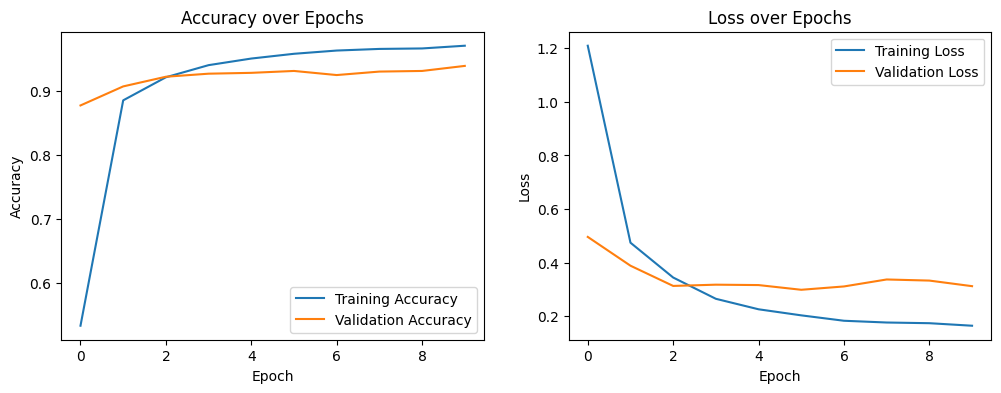

191/191 [==============================] - 1s 4ms/step


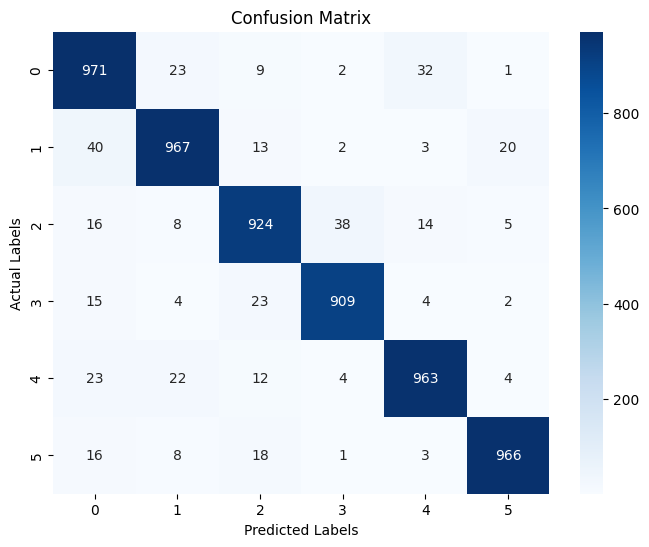

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1038
           1       0.94      0.93      0.93      1045
           2       0.92      0.92      0.92      1005
           3       0.95      0.95      0.95       957
           4       0.95      0.94      0.94      1028
           5       0.97      0.95      0.96      1012

    accuracy                           0.94      6085
   macro avg       0.94      0.94      0.94      6085
weighted avg       0.94      0.94      0.94      6085

191/191 [==============================] - 1s 5ms/step - loss: 0.3083 - accuracy: 0.9367
Test Loss: 0.3082999289035797
Test Accuracy: 0.9367296695709229


In [70]:

# plots training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# confusion matrix
y_pred = rnn_model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

print(classification_report(y_test, y_pred))

# test loss and accuracy evaluation
test_loss, test_accuracy = rnn_model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")